In [4]:
import ROOT as rt
import uproot
import numpy as np
from collections import OrderedDict
import csv
import os
import math
import sys
sys.path.append("/uscms/home/christiw/nobackup/CMSSW_11_3_4/src/MDS_CMSDAS2023/lib")

import importlib
import helper
importlib.reload(sys.modules['helper'])
from helper import  weight_calc, make_datacard

import tdrstyle
a = tdrstyle.setTDRStyle()

print(sys.version)

3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


In [36]:
fpath =OrderedDict()
tree = OrderedDict()

mass = [40]

OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

path = '/uscms/home/christiw/nobackup/CMSSW_11_3_4/src/MDS_CMSDAS2023/ntuples/'

for ct in OLD_CTAU:
    key = 'MC_40_'+str(ct)                       
    fpath[key] = path +  'ggH_HToSSTobbbb_MH-125_MS-40_ctau-'+str(ct)+'_137000pb_weighted.root'

NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']


# calculate the LLP proper decay length from the LLP four momentum

In [16]:
gLLP_ctau = {}
for k, T in tree.items():
    gLLP_decay_vertex = np.sqrt(T['gLLP_decay_vertex_x'].array()**2 + T['gLLP_decay_vertex_y'].array()**2 + T['gLLP_decay_vertex_z'].array()**2)
    gLLP_gamma = 1.0/np.sqrt(1-T['gLLP_beta'].array()**2)
    gLLP_ctau[k] = gLLP_decay_vertex/(T['gLLP_beta'].array()*gLLP_gamma)
    


# plot the LLP proper decay length

MC_40_1000 1165.0576459769288
MC_40_10000 8070.427937213506
 FCN=861.423 FROM MIGRAD    STATUS=CONVERGED      42 CALLS          43 TOTAL
                     EDM=4.32654e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -1.56972e-01   8.57023e-03   9.22889e-05  -1.09480e-01
   2  Slope       -8.58327e-03   4.59068e-05   4.94054e-07  -2.67341e+01
 FCN=1340.71 FROM MIGRAD    STATUS=CONVERGED      62 CALLS          63 TOTAL
                     EDM=3.84532e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.14058e+00   1.01307e-02   1.14041e-04  -7.20234e-02
   2  Slope       -1.23909e-03   9.74364e-06   1.09666e-07   1.84845e+01


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


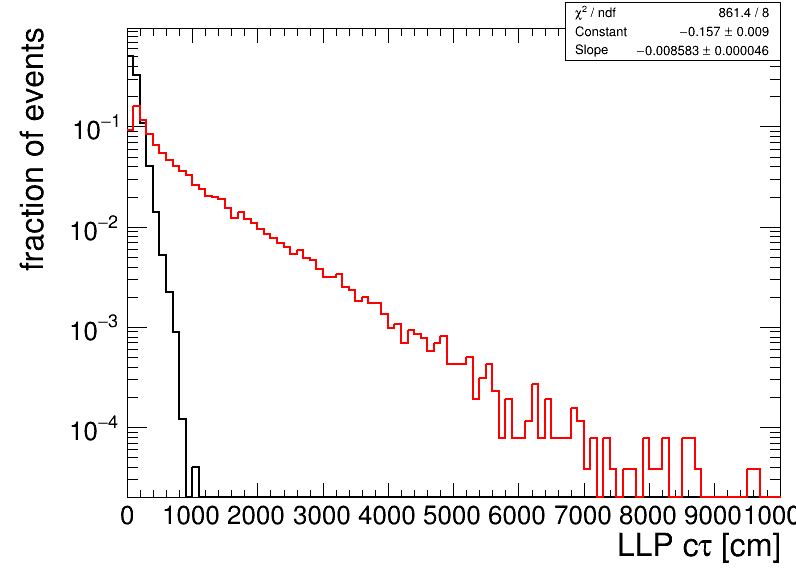

In [21]:
c = rt.TCanvas('c','c', 800, 600)
h = {}

for i, k in enumerate(tree.keys()):
    h[k] = rt.TH1D('', '', 100, 0, 10000)
    h[k].SetXTitle('LLP c#tau [cm]')
    h[k].SetYTitle('fraction of events')
    for j in range(len(gLLP_ctau[k])): h[k].Fill(gLLP_ctau[k][j][0])
    h[k].Scale(1./h[k].Integral())
    h[k].SetLineColor(i+1)
    h[k].Draw('hist same')
    

    ####### perform exponential fit ######
    h[k].Fit('expo')
    fit = h[k].GetFunction('expo')
    print(k, -1./fit.GetParameter(1)*10)
    #######################################
    
c.SetLogy()
c.Draw()


# reweight LLP lifetime 

In [23]:
def weight_calc(llp_ct, new_ctau, old_ctau):
    source = np.exp(-1.0*llp_ct/old_ctau)/old_ctau**2
    weight = 1.0/new_ctau**2 * np.exp(-1.0*llp_ct/new_ctau)/source
    return weight

MC_40_1000 1274.2132422957952
MC_40_10000 1032.9621053832093
 FCN=4104.9 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=5.01396e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.72208e+00   8.51163e-03   2.16374e-04  -1.25197e-03
   2  Slope       -7.84798e-03   3.93412e-05   1.00011e-06  -2.85801e-01
 FCN=429.03 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=1.29678e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.32563e+00   2.55014e-02   1.51379e-04   2.99635e-03
   2  Slope       -9.68090e-03   4.60636e-05   2.73401e-07   4.70266e+00


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


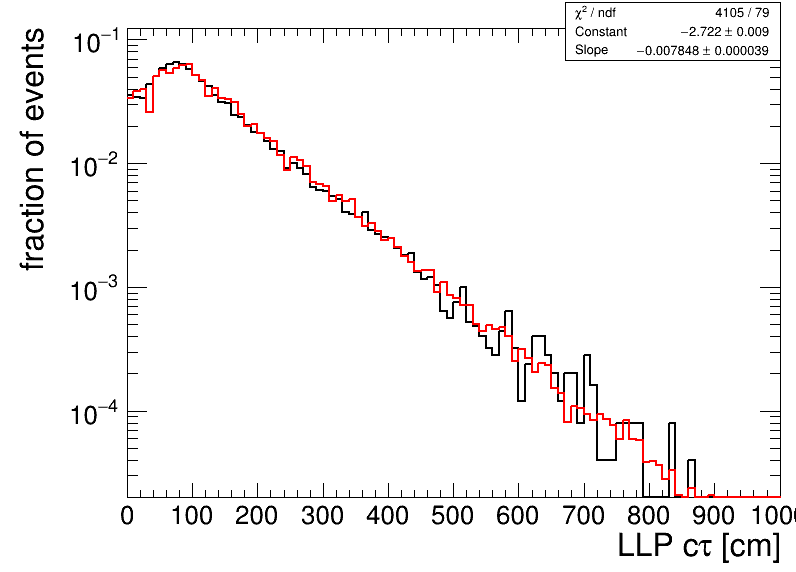

In [30]:
# reweight from 10m to 1m

c = rt.TCanvas('c','c', 800, 600)
h = {}

for i, k in enumerate(tree.keys()):
    h[k] = rt.TH1D('', '', 100, 0, 1000)
    h[k].SetXTitle('LLP c#tau [cm]')
    h[k].SetYTitle('fraction of events')
    if k == 'MC_40_1000': 
        for j in range(len(gLLP_ctau[k])): h[k].Fill(gLLP_ctau[k][j][0])
    else: 
        weight = weight_calc(np.sum(gLLP_ctau[k], axis = 1), 100,1000)
        for j in range(len(gLLP_ctau[k])): h[k].Fill(gLLP_ctau[k][j][0], weight[j])
    h[k].Scale(1./h[k].Integral())
    h[k].SetLineColor(i+1)
    h[k].Draw('hist same')
    

    ####### perform exponential fit ######
    h[k].Fit('expo')
    fit = h[k].GetFunction('expo')
    print(k, -1./fit.GetParameter(1)*10)

    #######################################
    
c.SetLogy()
c.Draw()


In [37]:
# Calculate the probability of LLP decaying in the muon system
for k, T in tree.items():
    # define endcap muon system region

    sel_ms = np.logical_and(T['gLLP_eta'].array() <2.4, np.abs(T['gLLP_decay_vertex_z'].array()) < 1100)
    sel_ms = np.logical_and(sel_ms, np.abs(T['gLLP_decay_vertex_z'].array()) > 400)
    sel_ms = np.logical_and(sel_ms, np.abs(T['gLLP_decay_vertex_r'].array()) < 695.5)
    print(k, np.count_nonzero(np.sum(sel_ms, axis = 1))/len(sel_ms))

MC_40_100 0.48330683624801274
MC_40_1000 0.4630021986807915
MC_40_10000 0.3425983037779491
MC_40_100000 0.10125984251968503
